In [1]:
import numpy as np
import pandas as pd
import random as rd
import glob

import data_loader as dl
import autoencoder
import trainer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from numpy import dot
from numpy.linalg import norm
import scipy.stats

from sklearn.decomposition import PCA
from cmapPy.pandasGEXpress.parse import parse

In [2]:
# Function: parses and vectorize GCTX file from the CMap database with optional subsetting. 
# Min-max and log2+1 scaling are completed during vectorization by default.
# Returns an array of inst_ids as keys and an array of response vectors 
def load_CMap(path, subset = False, in_format = "counts", min_max = True, log2_1 = True):
    
    if ".gctx" in path:
        gct = parse(path)
        df = gct.data_df
    elif ".csv" in path:
        df = pd.read_csv(path, sep = ',')
    elif ".txt" in path:
        df = pd.read_csv(path, sep='\t')
    else:
        print("Unsupported file type - options are gctx, txt, and csv")
        return -1
    
    if subset != False:
        df_out = df.iloc[:,0:subset]
        del df
        return df_out
    else:
        return df

In [3]:
def get_mean_vecs_by_metaData(meta_data, vec_dict, val_id, group_id):
    
    mean_vecs = dict.fromkeys(set(meta_data[group_id]), None)
    
    for group in list(mean_vecs.keys()):
        val_ids = np.array(meta_data[val_id])[np.where(meta_data[group_id] == group)]
        try:
            mean_vecs[group] = np.mean([vec_dict[v] for v in val_ids], axis = 0)
        except:
            mean_vecs.pop(group)
            print("Pop")
    
    # Computation of PCs to visualize divergent clusters within the control condition
    """ 
    pca = PCA(n_components=2)
    pc_df = pd.DataFrame(data = pca.fit_transform(control_vec_set), columns = ['PC1', 'PC2'])
    plt.scatter(pc_df.PC1, pc_df.PC2)
    plt.show()
    """
    return mean_vecs

In [4]:
def subtract_mean_vec(raw_vec_dict, mean_vec_dict, meta_data, vec_id, group_id):
    
    # Subtract the mean DMSO condition from all response vectors for each cell type 
    normed_vec_dict = dict.fromkeys(raw_vec_dict.keys(), None)
    
    for group in mean_vec_dict.keys():

        vec_ids = np.array(meta_data[vec_id])[np.where(meta_data[group_id] == group)]
        group_mean = mean_vec_dict[group]

        for ID in vec_ids:
            normed_vec_dict[ID] = raw_vec_dict[ID] - group_mean
            #if vec_id in list(control_meta_data.inst_id):
            #   plt.plot(vectors[vec_id])
            #   plt.plot(control_normed_vecs[vec_id])
            #   plt.show()

    return normed_vec_dict

In [5]:
# Helper functions for getting cosine similarity from drug response vectors.
def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

def combs_cos_sim(arr):

    if len(arr) < 2:
        return 1
    combs = list(combinations(np.arange(len(arr)), 2))
    sims = [cos_sim(arr[c[0]], arr[c[1]]) for c in combs]

    return np.mean(sims)

def combs_pearson_sim(arr):

    if len(arr) < 2:
        return 1
    combs = list(combinations(np.arange(len(arr)), 2))
    sims = [np.corrcoef(arr[c[0]], arr[c[1]]) for c in combs]

    return np.mean(sims)

In [6]:
def vecs_to_PCA(vecs, meta, dims = 2):
    pca = PCA(n_components = dims)
    pc_df = pd.DataFrame(data = pca.fit_transform(pd.DataFrame(vecs).transpose()), columns = ['PC1', 'PC2'])
    pc_df['sig_id'] = vecs.keys()
    pc_df['cell_id'] = pc_df['sig_id'].map(dict(zip(meta.sig_id,meta.cell_id)))
    pc_df['pert_iname'] = pc_df['sig_id'].map(dict(zip(meta.sig_id,meta.pert_iname)))
    pc_df['appPert_id'] = pc_df['sig_id'].map(dict(zip(meta.sig_id,meta.appPert_id)))
    return pc_df

In [7]:
def compute_pert_cos_sims(vectors, meta_data):
    
    # Take only meta data for which there are expression vectors
    meta_data = meta_data[meta_data['sig_id'].isin(list(vectors.keys()))]
    
    # Populate a dict of cell types with their corresponding mean DMSO vector
    print('Computing DMSO reference...\n')
    control_meta_data = meta_data[meta_data['pert_id'] == 'DMSO']
    cell_mean_DMSO_vecs = get_mean_vecs_by_metaData(control_meta_data, vectors, 'inst_id', 'cell_id')
    
    # Subtract the mean DMSO condition from all response vectors for each cell type
    print('Norming to DMSO reference...\n')
    cell_normed_vectors = subtract_mean_vec(vectors, cell_mean_DMSO_vecs, meta_data, 'inst_id', 'cell_id')
    
    # Get all inst_ids that match a perturbation-cell pair (vector), compute the mean.
    print('Computing perturbation means...\n')
    mean_cell_normed_vectors = get_mean_vecs_by_metaData(meta_data, cell_normed_vectors, 'inst_id', 'vec_id')
    
    meta_data = meta_data[meta_data['vec_id'].isin(list(mean_cell_normed_vectors.keys()))]
    
    # Get all mean vectors that match an applied perturbation (drug, dose, and time), compute cosine similarity
    cos_sims = dict()
    
    print('Getting cosine similarities...\n')
    for exp in set(meta_data.appPert_id):
        vec_ids = set(np.array(meta_data.vec_id)[np.where(meta_data.appPert_id == exp)])
        cos_sims[exp] = combs_cos_sim(np.array([mean_cell_normed_vectors[i] for i in vec_ids]))

    #plt.hist(list(cos_sims.values()), list(cos_sims.values()))
    
    return cos_sims
    
    

In [32]:
# Parse the CMap expression data. From into key + vector tuples
path = "input_data/GSE92742_Level5_isgold_drugs_lm_hf_modZ.csv"

df = load_CMap(path, subset = False)
df_sub = df.iloc[:,0:100000]

In [33]:
native_vectors = dict(dl.vectorize(df_sub, scale_min_max=False, scale_log2_1=False))
native_vectors.pop('Unnamed: 0')

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [34]:
# Read in the meta data for the perturbations
meta_path = "GSE92742_Broad_LINCS_sig_info.txt"
meta_data = pd.read_csv(meta_path, sep = '\t')

meta_data['pert_time'] = meta_data['pert_time'].apply(str)
meta_data['pert_dose'] = meta_data['pert_dose'].apply(str)
meta_data['appPert_id'] = meta_data[['pert_id', 'pert_dose', 'pert_time']].agg('_'.join, axis=1)

# Take only meta data for which there are expression vectors
meta_data = meta_data[meta_data['sig_id'].isin(list(native_vectors.keys()))]

<ipython-input-34-32715ee25efd>:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_data = pd.read_csv(meta_path, sep = '\t')


In [35]:
cell_counts = dict()

for c in set(meta_data.cell_id):
    count = list(meta_data.cell_id).count(c)
    #if count >= min_count:
    cell_counts[c] = count
cell_counts = dict(sorted(cell_counts.items(), key=lambda item: item[1], reverse = True))

In [ ]:
pert_counts = dict()
pert_set = set(meta_data.appPert_id)

for p in pert_set:
    count = list(meta_data.appPert_id).count(p)
    #if count >= min_count:
    pert_counts[p] = count
pert_counts = dict(sorted(pert_counts.items(), key=lambda item: item[1], reverse = True))

In [ ]:
pca_df = vecs_to_PCA(native_vectors, meta_data)
pca_df = pca_df[pca_df['appPert_id'] == (list(pert_counts.keys())[6])]
pca_df = pca_df[pca_df['cell_id'].isin(list(cell_counts.keys())[0:8])]
sns.scatterplot(x = 'PC1', y = 'PC2', data = pca_df, hue = 'cell_id')
plt.title(list(pca_df.pert_iname)[0])


In [ ]:
pca_df = vecs_to_PCA(latent_vectors, meta_data)
pca_df = pca_df[pca_df['appPert_id'] == (list(pert_counts.keys())[6])]
pca_df = pca_df[pca_df['cell_id'].isin(list(cell_counts.keys())[0:8])]
sns.scatterplot(x = 'PC1', y = 'PC2', data = pca_df, hue = 'cell_id')
plt.title(list(pca_df.pert_iname)[0])


### Now map the native responses to the latent space to see if there is improved alignment

In [36]:
# Set up a Torch vectors class for the dataloader
class TorchVectors(Dataset):

    # Data comes in as a list
    def __init__(self, train_pairs):
        self.train_pairs = train_pairs

    def __len__(self):
        return len(self.train_pairs)

    def __getitem__(self, idx):
        key = self.train_pairs[idx][0]
        sample = self.train_pairs[idx][1]
        return key, torch.from_numpy(sample).float()

In [37]:
# Prep for passing to the model
vectors_torch = TorchVectors(list(native_vectors.items()))
val_loader = DataLoader(vectors_torch, batch_size=1, pin_memory=True, shuffle=False)

In [38]:
agg_factor = 'pert_iname'

# Get all mean vectors that match an applied perturbation (drug, dose, and time), compute cosine similarity
cor_native = dict()

for exp in set(meta_data[agg_factor]):

    sig_ids = set(np.array(meta_data.sig_id)[np.where(meta_data[agg_factor] == exp)])
    cor_native[exp] = combs_cos_sim(np.array([native_vectors[i] for i in sig_ids]))

(array([  21.,   85.,  284., 1135., 1418., 1160.,  446.,   40.,    4.,
        2779.]),
 array([-0.43611521, -0.29250369, -0.14889217, -0.00528065,  0.13833087,
         0.28194239,  0.42555392,  0.56916544,  0.71277696,  0.85638848,
         1.        ]),
 <BarContainer object of 10 artists>)

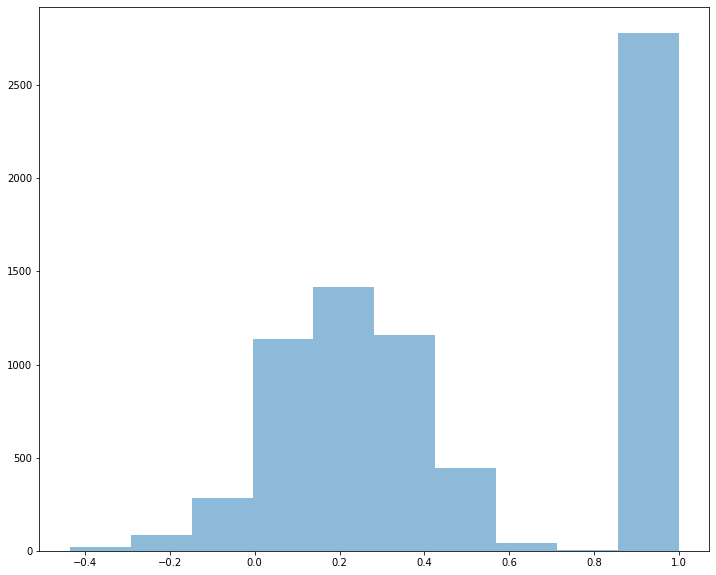

In [39]:
plt.figure(figsize = (12,10))
plt.hist(cor_native.values(), label = 'Native', alpha = 0.5)

In [62]:
files[3]

'trained_model_params/modZ_input\\0.00237588_leakyReLu_960_1000_model_best.pth'

Linear(in_features=960, out_features=1100, bias=False)


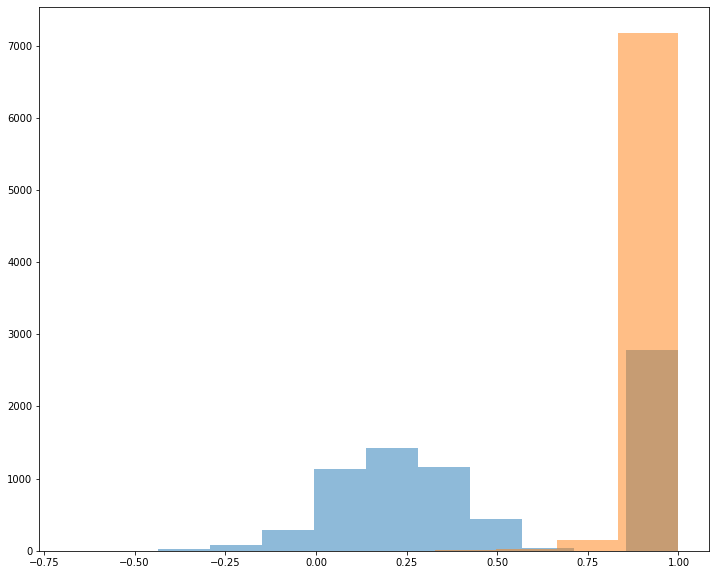

In [40]:
#params = torch.load("leakyReLu_960_1100_modZ.pth")

from datetime import date

files = glob.glob("trained_model_params/modZ_input/*.pth")
files = ['0.00189921_drugsOnly_leakyReLu_960_1100_model_best.pth']

for f in files:
    
    # Retrieve the architecture of the model
    params = torch.load(f)
    latent_size, input_size = params['state_dict']['net.0.weight'].shape
    weights_encode = torch.nn.Parameter(params['state_dict']['net.0.weight'])
    weights_decode = torch.nn.Parameter(params['state_dict']['net.2.weight'])


    # Initialize the encoding layer, apply weights
    to_latent_nn = nn.Linear(input_size, latent_size, bias=False)
    to_latent_nn.weight = weights_encode
    to_latent_nn.eval()
    
    to_latent_nn.cuda()
    output = dict()

    for idx, batch in enumerate(val_loader):
        key, vals = batch[0][0], batch[1]
        inputs = Variable(vals).cuda()
        with torch.no_grad():
            output[key] = to_latent_nn(inputs)
    to_latent_nn.cpu()

    latent_vectors = dict()

    for key, vals in output.items():
        latent_vectors[key] = vals.cpu().numpy()[0]
    

    print(to_latent_nn)
    
    agg_factor = 'pert_iname'

    # Get all mean vectors that match an applied perturbation (drug, dose, and time), compute cosine similar
    #cor_native = dict()
    cor_latent = dict()

    for exp in set(meta_data[agg_factor]):

        sig_ids = set(np.array(meta_data.sig_id)[np.where(meta_data[agg_factor] == exp)])

     #   cor_native[exp] = combs_cos_sim(np.array([native_vectors[i] for i in sig_ids]))
        cor_latent[exp] = combs_cos_sim(np.array([latent_vectors[i] for i in sig_ids]))
        
    plt.figure(figsize = (12,10))
    plt.hist(cor_native.values(), label = 'Native', alpha = 0.5)
    plt.hist(cor_latent.values(), label = 'Latent', alpha = 0.5)
    
    
    today = date.today()

    results = pd.DataFrame({'Native Key' : list(cor_native.keys()), 'Native Alignment': list(cor_native.values()), 'Latent Key': list(cor_latent.keys()),  'Latent Alignment': list(cor_latent.values())}) 
    results.to_csv(str(today) + '_' + str(files[0].split('\\')[-1].split('.pth')[0]) + '.csv')

#### Note that there are many possible metric for assessing the similarity of the drug responses (Euclidean, Peasron, cosine, etc.). My intuition is that cosine is preferable, seeing as were interested in the directionality of the response, rather matching the magnitude gene by gene. Cosine also shows the utility of the latent embedding more clearly as the change is more obvious.

In [45]:
pEF_vector = np.array(pd.read_csv("input_data/HFpEF_latent_vector.csv").pEF_vector)
data_path_pEF = "input_data/HF_LM_genes_DEG_data.csv"
pEF_vector = np.array(pd.read_csv(data_path_pEF).z_score_PEF)

In [46]:
pEF_alignment = dict()

for key, l_vec in native_vectors.items():
    pEF_alignment[key] = cos_sim(-pEF_vector,l_vec)

(array([2.000e+01, 2.930e+02, 2.136e+03, 6.666e+03, 9.506e+03, 7.240e+03,
        2.933e+03, 5.400e+02, 5.000e+01, 2.000e+00]),
 array([-0.13371135, -0.10363821, -0.07356507, -0.04349193, -0.01341879,
         0.01665435,  0.0467275 ,  0.07680064,  0.10687378,  0.13694692,
         0.16702006]),
 <BarContainer object of 10 artists>)

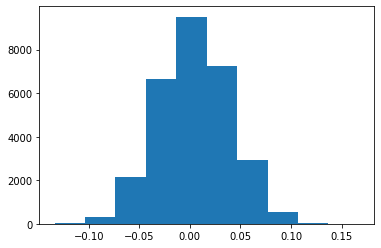

In [47]:
plt.hist(pEF_alignment.values())

In [31]:
for k, v in pEF_alignment.items():
    if (v > 0.5):
        print(meta_data[meta_data['sig_id'] == k]['pert_type'])

29973    trt_sh.cgs
Name: pert_type, dtype: object
31254    trt_sh.cgs
Name: pert_type, dtype: object
31938    trt_sh.cgs
Name: pert_type, dtype: object
173509    trt_sh.css
Name: pert_type, dtype: object
173746    trt_sh.css
Name: pert_type, dtype: object
175208    trt_sh.css
Name: pert_type, dtype: object
247046    trt_cp
Name: pert_type, dtype: object
247058    ctl_untrt
Name: pert_type, dtype: object
247138    ctl_untrt
Name: pert_type, dtype: object
247231    ctl_untrt
Name: pert_type, dtype: object
259953    trt_sh
Name: pert_type, dtype: object
260621    trt_sh
Name: pert_type, dtype: object
260694    trt_sh
Name: pert_type, dtype: object
260910    trt_sh
Name: pert_type, dtype: object
261004    trt_sh
Name: pert_type, dtype: object
261006    trt_sh
Name: pert_type, dtype: object
261034    trt_sh
Name: pert_type, dtype: object
261048    trt_sh
Name: pert_type, dtype: object
267047    trt_oe
Name: pert_type, dtype: object
267061    trt_oe
Name: pert_type, dtype: object
270141    

In [48]:
max(pEF_alignment.values())

0.1670200617042326